In [1238]:
cd Desktop/Formation_Ingenieur_Machine_Learning/P4_voelker_jean-florent

[Errno 2] No such file or directory: 'Desktop/Formation_Ingenieur_Machine_Learning/P4_voelker_jean-florent'
/Users/jfv/Desktop/Formation_Ingenieur_Machine_Learning/P4_voelker_jean-florent


In [1239]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import scipy.stats as st
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster
from datetime import datetime


pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 1000)

Chargement des fonctions d'exploration des données

In [1240]:
from matplotlib.collections import LineCollection
from scipy.cluster.hierarchy import dendrogram


def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks:  # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7, 6))

            # détermination des limites du graphique
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = min(pcs[d1, :]), max(
                    pcs[d1, :]), min(pcs[d2, :]), max(pcs[d2, :])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                           pcs[d1, :], pcs[d2, :],
                           angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0, 0], [x, y]] for x, y in pcs[[d1, d2]].T]
                ax.add_collection(LineCollection(
                    lines, axes=ax, alpha=.1, color='black'))

            # affichage des noms des variables
            if labels is not None:
                for i, (x, y) in enumerate(pcs[[d1, d2]].T):
                    print(i)
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i], fontsize='14', ha='center',
                                 va='center', rotation=label_rotation, color="blue", alpha=0.5)

            # affichage du cercle
            circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1+1, round(100*pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(
                d2+1, round(100*pca.explained_variance_ratio_[d2], 1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)


def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None, legend=None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig = plt.figure(figsize=(7, 6))

            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1],
                            X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                plt.scatter(X_projected[:, d1], X_projected[:, d2],
                            c=illustrative_var, alpha=alpha, cmap="viridis")
                if legend is not None:
                    plt.colorbar(label=legend)

            # affichage des labels des points
            if labels is not None:
                for i, (x, y) in enumerate(X_projected[:, [d1, d2]]):
                    plt.text(x, y, labels[i], fontsize='14',
                             ha='center', va='center')

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(
                d1+1, round(100*pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('F{} ({}%)'.format(
                d2+1, round(100*pca.explained_variance_ratio_[d2], 1)))

            plt.title(
                "Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)


def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(), c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)


def plot_dendrogram(Z, names):
    plt.figure(figsize=(10, 25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels=names,
        orientation="left",
    )
    plt.show()


def eta_squared(x, y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x == classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

J'importe les différents datasets

In [1241]:
df_olist_customers_dataset = pd.read_csv(
    'olist_customers_dataset.csv', delimiter=',')
df_olist_geolocation_dataset = pd.read_csv(
    'olist_geolocation_dataset.csv', delimiter=',')
df_olist_order_items_dataset = pd.read_csv(
    'olist_order_items_dataset.csv', delimiter=',')
df_olist_order_payments_dataset = pd.read_csv(
    'olist_order_payments_dataset.csv', delimiter=',')
df_olist_order_reviews_dataset = pd.read_csv(
    'olist_order_reviews_dataset.csv', delimiter=',')
df_olist_orders_dataset = pd.read_csv(
    'olist_orders_dataset.csv', delimiter=',')
df_olist_products_dataset = pd.read_csv(
    'olist_products_dataset.csv', delimiter=',')
df_olist_sellers_dataset = pd.read_csv(
    'olist_sellers_dataset.csv', delimiter=',')
df_product_category_name_translation = pd.read_csv(
    'product_category_name_translation.csv', delimiter=',')

Je regarde les colonnes pour identifier les clefs primaires et secondaires reliants les différentes tables.

In [1242]:
df_olist_customers_dataset.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [1243]:
df_olist_geolocation_dataset.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [1244]:
df_olist_order_items_dataset.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [1245]:
df_olist_order_payments_dataset.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [1246]:
df_olist_order_reviews_dataset.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [1247]:
df_olist_orders_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [1248]:
df_olist_products_dataset.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [1249]:
df_olist_sellers_dataset.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [1250]:
df_product_category_name_translation.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [1251]:
df_product_category_name_translation.explode('product_category_name')

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor
5,esporte_lazer,sports_leisure
6,perfumaria,perfumery
7,utilidades_domesticas,housewares
8,telefonia,telephony
9,relogios_presentes,watches_gifts


J'étudie le nombre d'enregistrement et la cardinalité entre les tables "df_olist_customers_dataset" et "df_olist_orders_dataset"

In [1252]:
df_olist_orders_dataset.shape[0]

99441

In [1253]:
df_olist_customers_dataset.merge(
    df_olist_orders_dataset, on='customer_id', how='inner').shape[0]

99441

In [1254]:
df_olist_customers_dataset.merge(
    df_olist_orders_dataset, on='customer_id', how='right').shape[0]

99441

In [1255]:
df_olist_customers_dataset.merge(
    df_olist_orders_dataset, on='customer_id', how='left').shape[0]

99441

J'ai une cardinalité de 1 : 1 pour les 2 tables "df_olist_customers_dataset" et "df_olist_orders_dataset"

Je regarde maintenant la cardinalité entre "df_olist_orders_dataset" et "df_olist_order_reviews_dataset"

In [1256]:
df_olist_order_reviews_dataset.shape[0]

99224

In [1257]:
df_olist_orders_dataset.merge(
    df_olist_order_reviews_dataset, on='order_id', how='inner').shape[0]

99224

In [1258]:
df_olist_orders_dataset.merge(
    df_olist_order_reviews_dataset, on='order_id', how='right').shape[0]

99224

In [1259]:
df_olist_orders_dataset.merge(
    df_olist_order_reviews_dataset, on='order_id', how='left').shape[0]

99992

In [1260]:
99992-99224

768

Il y a 768 commandes sans review. Je décide de les retirer -> inner join

Je regarde maintenant la cardinalité entre "df_olist_orders_dataset" et "df_olist_order_items_dataset"

In [1261]:
df_olist_order_items_dataset.shape[0]

112650

In [1262]:
df_olist_orders_dataset.merge(
    df_olist_order_items_dataset, on='order_id', how='inner').shape[0]

112650

In [1263]:
df_olist_orders_dataset.merge(
    df_olist_order_items_dataset, on='order_id', how='right').shape[0]

112650

In [1264]:
df_olist_orders_dataset.merge(
    df_olist_order_items_dataset, on='order_id', how='left').shape[0]

113425

In [1265]:
113425-112650

775

Il y a 775 commandes qui n'ont pas de sous items et donc sans aucun lien vers un produit. Je décide de retirer ces lignes -> inner join

Nous sommes dans le cas de figure où des tables ont été exportées séparément.

Après analyse je décide de ne pas garder les tables "olist_sellers_dataset", "df_olist_order_payments_dataset", "olist_products_dataset" et "product_category_name_translation".

Sur les autres DataFrames, je fais la sélection suivante:

Je joins les DataFrames "df_olist_customers_dataset" et "df_olist_orders_dataset"

In [1266]:
df_olist_custumer = df_olist_customers_dataset[['customer_id', 'customer_unique_id']].merge(
    df_olist_orders_dataset[['order_id', 'customer_id', 'order_purchase_timestamp']], left_on='customer_id', right_on='customer_id')

Je joins les DataFrames "df_olist_custumer" et "df_olist_order_reviews_dataset"

In [1267]:
df_olist_custumer = df_olist_custumer.merge(df_olist_order_reviews_dataset[[
                                            'order_id', 'review_score']], left_on='order_id', right_on='order_id')

Je joins les DataFrames "df_olist_custumer" et "df_olist_order_items_dataset"

In [1268]:
df_olist_custumer = df_olist_custumer.merge(df_olist_order_items_dataset[[
                                            'order_id', 'price']], left_on='order_id', right_on='order_id')

In [1269]:
df_olist_custumer

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,review_score,price
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,4,124.99
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,5,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,5,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,5,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,5,230.00
...,...,...,...,...,...,...
112367,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,6760e20addcf0121e9d58f2f1ff14298,2018-04-07 15:48:17,4,74.90
112368,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,9ec0c8947d973db4f4e8dcf1fbfa8f1b,2018-04-04 08:20:22,5,114.90
112369,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,fed4434add09a6f332ea398efd656a5c,2018-04-08 20:11:50,1,37.00
112370,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,e31ec91cea1ecf97797787471f98a8c2,2017-11-03 21:08:33,5,689.00


Je retire les variables qui ne nous servent plus 'order_id','customer_id'

In [1270]:
df_olist_custumer = df_olist_custumer.drop(['order_id', 'customer_id'], axis=1)

In [1271]:
df_olist_custumer

,customer_unique_id,order_purchase_timestamp,review_score,price
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,4,124.99
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,5,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,5,139.94
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,5,149.94
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,5,230.00
...,...,...,...,...
112367,1a29b476fee25c95fbafc67c5ac95cf8,2018-04-07 15:48:17,4,74.90
112368,d52a67c98be1cf6a5c84435bd38d095d,2018-04-04 08:20:22,5,114.90
112369,e9f50caf99f032f0bf3c55141f019d99,2018-04-08 20:11:50,1,37.00
112370,73c2643a0a458b49f58cea58833b192e,2017-11-03 21:08:33,5,689.00


Je regarde le taux de remplissage des variables

In [1272]:
df_analyzed = df_olist_custumer

nb_lignes = df_analyzed.index.size

rows = []

for nom_colonne in df_analyzed.columns.values:
    nb_na = df_analyzed[nom_colonne].isna().sum()
    rate_na = 100 * (1 - nb_na/nb_lignes)
    rows.append([nom_colonne, nb_na, rate_na])

df_remplissage_colonnes = pd.DataFrame(rows, columns=[
                                       "Nom", "nb na", "% remplissage"]).sort_values(by=["% remplissage"], ascending=False)
df_remplissage_colonnes

,Nom,nb na,% remplissage
0,customer_unique_id,0,100.0
1,order_purchase_timestamp,0,100.0
2,review_score,0,100.0
3,price,0,100.0


In [1273]:
df_olist_custumer

,customer_unique_id,order_purchase_timestamp,review_score,price
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,4,124.99
1,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,5,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,5,139.94
3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,5,149.94
4,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,5,230.00
...,...,...,...,...
112367,1a29b476fee25c95fbafc67c5ac95cf8,2018-04-07 15:48:17,4,74.90
112368,d52a67c98be1cf6a5c84435bd38d095d,2018-04-04 08:20:22,5,114.90
112369,e9f50caf99f032f0bf3c55141f019d99,2018-04-08 20:11:50,1,37.00
112370,73c2643a0a458b49f58cea58833b192e,2017-11-03 21:08:33,5,689.00


In [1274]:
df_olist_custumer_V2 = df_olist_custumer.sort_values(
    by=['order_purchase_timestamp'], ascending=True).copy()
df_olist_custumer_V2

,customer_unique_id,order_purchase_timestamp,review_score,price
95705,b7d76e111c89f7ebf14761390f0f7d17,2016-09-04 21:15:19,1,39.99
95706,b7d76e111c89f7ebf14761390f0f7d17,2016-09-04 21:15:19,1,32.90
79698,4854e9b3feff728c13ee5fc7d1547e92,2016-09-05 00:15:34,1,59.50
23952,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15 12:16:38,1,44.99
23951,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15 12:16:38,1,44.99
...,...,...,...,...
95601,5c58de6fb80e93396e2f35642666b693,2018-08-29 14:18:23,5,209.00
558,7febafa06d9d8f232a900a2937f04338,2018-08-29 14:18:28,5,45.90
56358,b701bebbdf478f5500348f03aff62121,2018-08-29 14:52:00,3,24.90
75981,24ac2b4327e25baf39f2119e4228976a,2018-08-29 15:00:37,5,84.99


Je créé un dataframe pour les variables dont il faut récupérer la dernière valeur.

In [1275]:
df_part_1 = df_olist_custumer_V2[['customer_unique_id', 'order_purchase_timestamp',
                                  'review_score']].drop_duplicates(subset='customer_unique_id', keep='last')
df_part_1

,customer_unique_id,order_purchase_timestamp,review_score
95706,b7d76e111c89f7ebf14761390f0f7d17,2016-09-04 21:15:19,1
79698,4854e9b3feff728c13ee5fc7d1547e92,2016-09-05 00:15:34,1
23950,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15 12:16:38,1
102051,0eb1ee9dba87f5b36b4613a65074337c,2016-10-02 22:07:52,1
62311,2f64e403852e6893ae37485d5fcacdaf,2016-10-03 16:56:50,4
...,...,...,...
95601,5c58de6fb80e93396e2f35642666b693,2018-08-29 14:18:23,5
558,7febafa06d9d8f232a900a2937f04338,2018-08-29 14:18:28,5
56358,b701bebbdf478f5500348f03aff62121,2018-08-29 14:52:00,3
75981,24ac2b4327e25baf39f2119e4228976a,2018-08-29 15:00:37,5


Je créé un dataframe pour les variables dont il faut récupérer la somme.

In [1276]:
df_part_2 = df_olist_custumer_V2[['customer_unique_id', 'price']].groupby(
    'customer_unique_id').sum()
df_part_2

,price
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
0000f46a3911fa3c0805444483337064,69.00
0000f6ccb0745a6a4b88665a16c9f078,25.99
0004aac84e0df4da2b147fca70cf8255,180.00
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,1570.00
fffea47cd6d3cc0a88bd621562a9d061,64.89
ffff371b4d645b6ecea244b27531430a,89.90


Je créé la variable fréquence.

In [1277]:
df_part_3 = df_olist_custumer_V2[[
    'customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').count()
df_part_3['frequence'] = df_part_3['order_purchase_timestamp']
df_part_3 = df_part_3[['frequence']]
df_part_3

,frequence
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,1
0000b849f77a49e4a4ce2b2a4ca5be3f,1
0000f46a3911fa3c0805444483337064,1
0000f6ccb0745a6a4b88665a16c9f078,1
0004aac84e0df4da2b147fca70cf8255,1
...,...
fffcf5a5ff07b0908bd4e2dbc735a684,2
fffea47cd6d3cc0a88bd621562a9d061,1
ffff371b4d645b6ecea244b27531430a,1


Je créé le dataframe final e joinant les 3 dataframes créés:

In [1278]:
df_olist_custumer_V3 = pd.merge(df_part_1, df_part_2, on='customer_unique_id')
df_olist_custumer_V3 = pd.merge(
    df_olist_custumer_V3, df_part_3, on='customer_unique_id')
df_olist_custumer_V3

,customer_unique_id,order_purchase_timestamp,review_score,price,frequence
0,b7d76e111c89f7ebf14761390f0f7d17,2016-09-04 21:15:19,1,72.89,2
1,4854e9b3feff728c13ee5fc7d1547e92,2016-09-05 00:15:34,1,59.50,1
2,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-15 12:16:38,1,134.97,3
3,0eb1ee9dba87f5b36b4613a65074337c,2016-10-02 22:07:52,1,100.00,1
4,2f64e403852e6893ae37485d5fcacdaf,2016-10-03 16:56:50,4,21.90,1
...,...,...,...,...,...
94716,5c58de6fb80e93396e2f35642666b693,2018-08-29 14:18:23,5,418.00,2
94717,7febafa06d9d8f232a900a2937f04338,2018-08-29 14:18:28,5,45.90,1
94718,b701bebbdf478f5500348f03aff62121,2018-08-29 14:52:00,3,24.90,1
94719,24ac2b4327e25baf39f2119e4228976a,2018-08-29 15:00:37,5,84.99,1


Je transforme la date de commande en nombre de jours écoulés depuis la 1ère commande enregistrée dans la BDD.

In [1279]:
date_reference = min(pd.to_datetime(
    df_olist_orders_dataset['order_purchase_timestamp']))

Je convertis 'order_purchase_timestamp' en type datetime

In [1280]:
df_olist_custumer_V3['order_purchase_timestamp'] = pd.to_datetime(
    df_olist_custumer_V3['order_purchase_timestamp'])

Je remplace alors 'order_purchase_timestamp' par la différence : 'order_purchase_timestamp' -date_reference

In [1281]:
df_olist_custumer_V3['order_purchase_timestamp'] = (
    df_olist_custumer_V3['order_purchase_timestamp']-date_reference)/np.timedelta64(1, 'D')

In [1282]:
df_olist_custumer_V3

,customer_unique_id,order_purchase_timestamp,review_score,price,frequence
0,b7d76e111c89f7ebf14761390f0f7d17,0.000000,1,72.89,2
1,4854e9b3feff728c13ee5fc7d1547e92,0.125174,1,59.50,1
2,830d5b7aaa3b6f1e9ad63703bec97d23,10.625914,1,134.97,3
3,0eb1ee9dba87f5b36b4613a65074337c,28.036493,1,100.00,1
4,2f64e403852e6893ae37485d5fcacdaf,28.820498,4,21.90,1
...,...,...,...,...,...
94716,5c58de6fb80e93396e2f35642666b693,723.710463,5,418.00,2
94717,7febafa06d9d8f232a900a2937f04338,723.710521,5,45.90,1
94718,b701bebbdf478f5500348f03aff62121,723.733808,3,24.90,1
94719,24ac2b4327e25baf39f2119e4228976a,723.739792,5,84.99,1


J'étudie les variables une à une :

Variable 'order_purchase_timestamp'

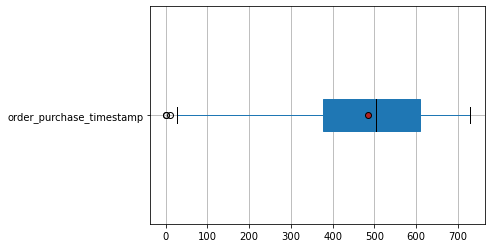

In [1283]:
medianprops = {'color': "black"}
meanprops = {'marker': 'o', 'markeredgecolor': 'black',
             'markerfacecolor': 'firebrick'}
df_olist_custumer_V3.boxplot(column="order_purchase_timestamp", showfliers=True, medianprops=medianprops,
                             vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

J'observe que quelques commandes se détachent au tout début des commandes.

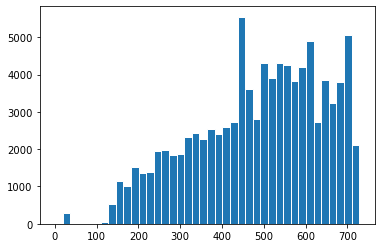

In [1284]:
plt.hist(
    df_olist_custumer_V3['order_purchase_timestamp'], 40, edgecolor='white')
plt.show()

Je retire les commandes dont le 'order_purchase_timestamp' est inférieur à 100

In [1285]:
df_olist_custumer_V3 = df_olist_custumer_V3[df_olist_custumer_V3['order_purchase_timestamp'] > 100].copy(
)

Variable 'review_score'

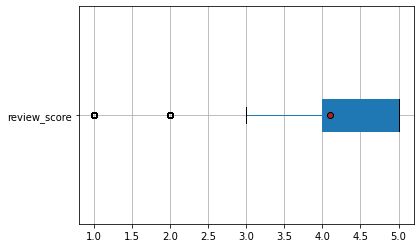

In [1286]:
df_olist_custumer_V3.boxplot(column="review_score", showfliers=True, medianprops=medianprops,
                             vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

Je ne remarque pas de valeurs aberrantes. (1-5)

Variable 'price'

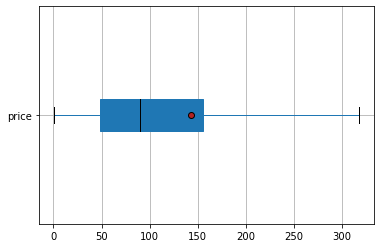

In [1287]:
df_olist_custumer_V3.boxplot(column="price", showfliers=False, medianprops=medianprops,
                             vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

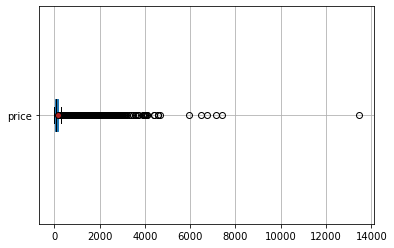

In [1288]:
df_olist_custumer_V3.boxplot(column="price", showfliers=True, medianprops=medianprops,
                             vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

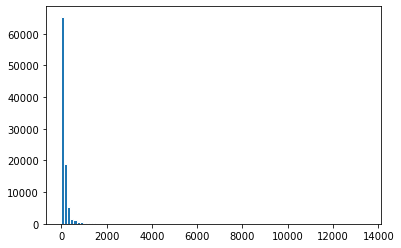

In [1289]:
plt.hist(df_olist_custumer_V3['price'], 100, edgecolor='white')
plt.show()

In [1290]:
df_olist_custumer_V3[df_olist_custumer_V3['price'] > 1000].shape[0]

979

Je décide de retirer les 979 clients ayant commandé plus de 1000 euros

In [1291]:
df_olist_custumer_V3 = df_olist_custumer_V3[df_olist_custumer_V3['price'] <= 1000]

Variable 'frequence'

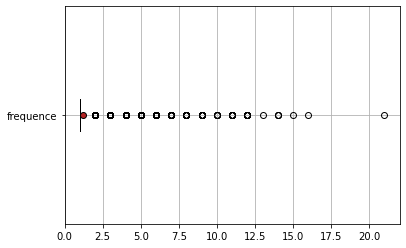

In [1292]:
df_olist_custumer_V3.boxplot(column="frequence", showfliers=True, medianprops=medianprops,
                             vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

In [1293]:
df_olist_custumer_V3[df_olist_custumer_V3['frequence']
                     > 1].shape[0]*100/df_olist_custumer_V3.shape[0]

12.35232428730417

Je remarque que peu de clients ont réalisés plusieurs commandes.

La variable 'order_purchase_timestamp' s'améliore quand elle décroit. Je préfère travailler avec une variable qui s'améliore en augmentant, j'inverse les valeurs pour cette variable.

In [1294]:
df_olist_custumer_V3['order_purchase_timestamp'] = max(
    df_olist_custumer_V3['order_purchase_timestamp'])-df_olist_custumer_V3['order_purchase_timestamp']

Je graphe les variables 2 à 2.

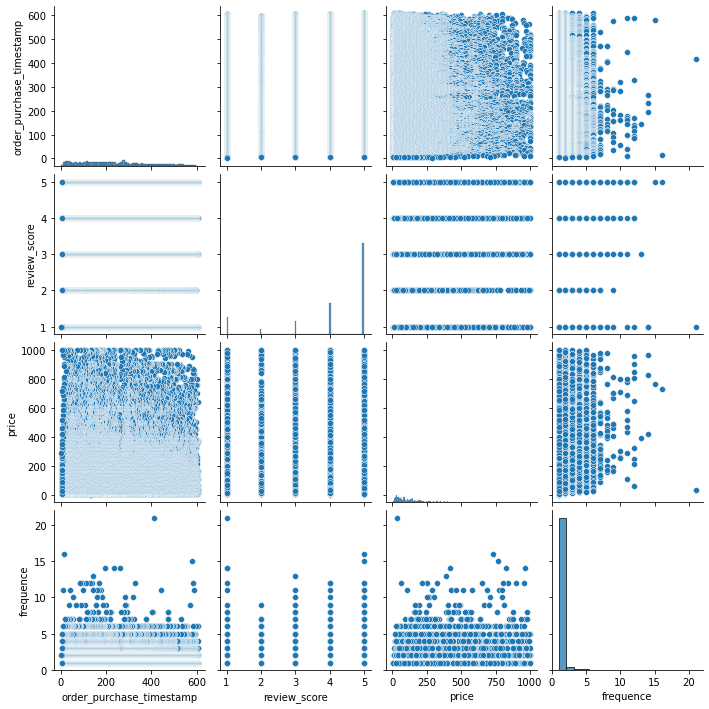

In [1295]:
df_bivarie = df_olist_custumer_V3.drop(['customer_unique_id'], axis=1)
sns.pairplot(df_bivarie, height=2.5)

In [1296]:
# préparation des données pour l'ACP
data = df_olist_custumer_V3[['price', 'frequence',
                             'order_purchase_timestamp', 'review_score']]
X = data.values
features = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

Je souhaite faire un dendrogramme mais comme j'ai plus de 90000 commandes, je commence par les regrouper en 100 clusters.

In [1297]:
# Clustering par K-means
km = KMeans(n_clusters=100)
km.fit(X_scaled)

clusters_kmeans = range(100)
centroids_after_kmeans = km.cluster_centers_

Je graphe un dendrogramme sur ce cluster de 100.

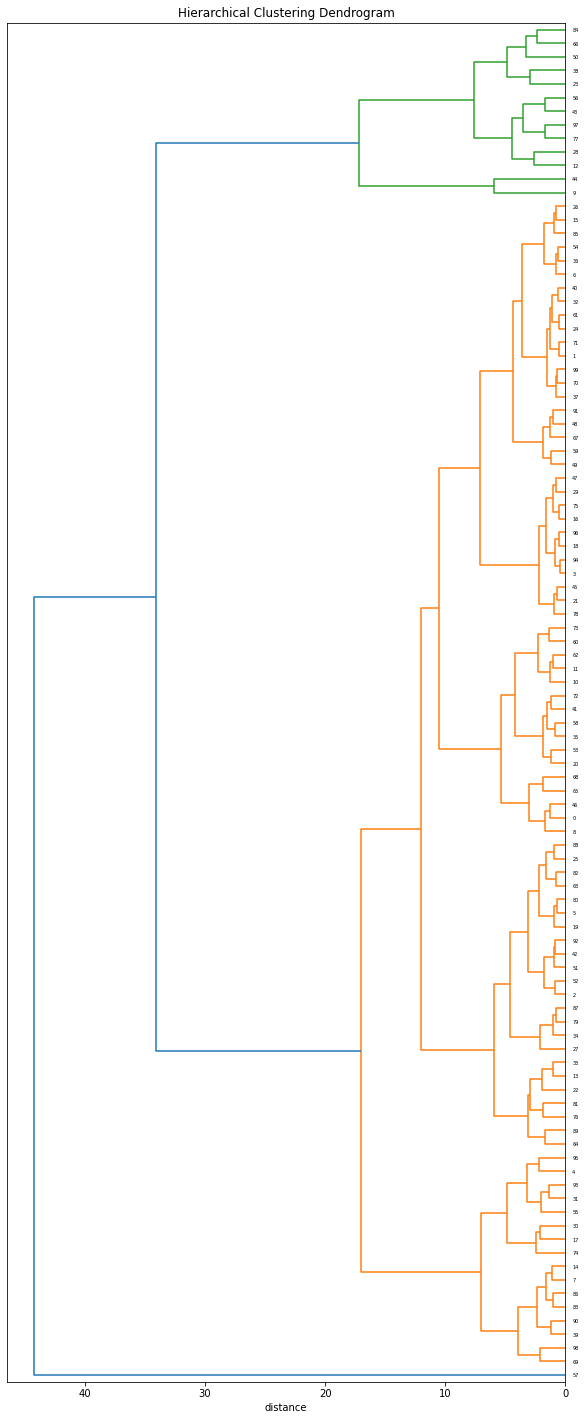

In [1298]:
# Clustering hiérarchique
Z = linkage(centroids_after_kmeans, 'ward')

# Affichage du dendrogramme
plot_dendrogram(Z, names=clusters_kmeans)

In [1299]:
# Nombre de clusters souhaités
n_clust = 3

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X_scaled)

KMeans(n_clusters=3)

In [1300]:
# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
n_comp = 4
pca = decomposition.PCA(n_components=n_comp).fit(X_scaled)
X_projected = pca.transform(X_scaled)

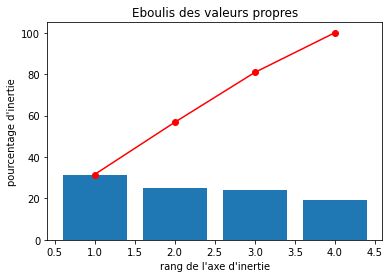

0
1
2
3


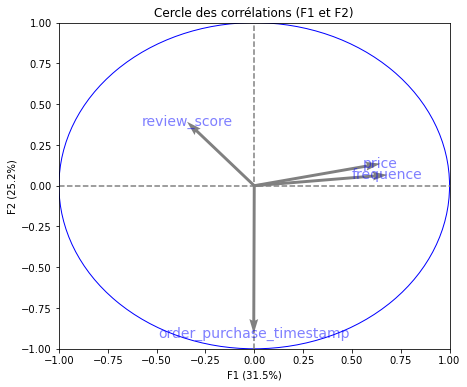

0
1
2
3


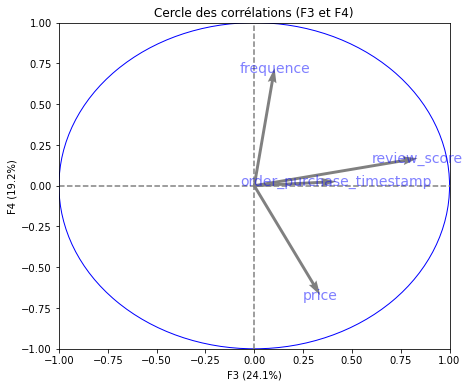

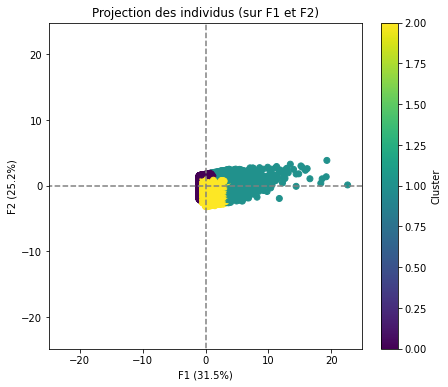

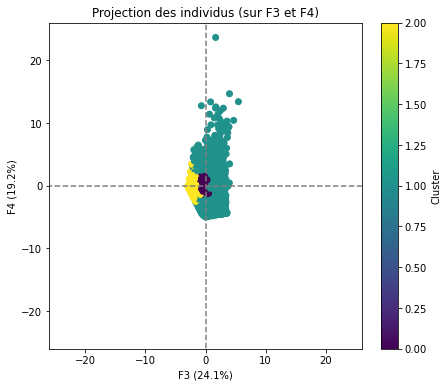

In [1301]:
# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_

display_circles(pcs, n_comp, pca, [(0, 1), (2, 3)], labels=np.array(features))


display_factorial_planes(X_projected, n_comp, pca, [(
    0, 1), (2, 3)], illustrative_var=clusters, legend="Cluster")

plt.show()

In [1302]:
df_olist_custumer_V3.to_csv('df_customer_ML.csv')